In [75]:
# parameters
config_dir = "../experiments"
exp_name = "014_output_viz/base"

In [79]:
%cd /kaggle/working

from pathlib import Path

from hydra import compose, initialize
from omegaconf import OmegaConf

with initialize(
    version_base=None, config_path=f"{config_dir}/{exp_name.split('/')[0]}"
):
    cfg = compose(
        config_name="config.yaml",
        overrides=[f"exp={exp_name.split('/')[-1]}"],
        return_hydra_config=True,
    )
import pickle

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns

# 定数定義
output_dir = Path("output/experiments/014_output_viz/base")

# カラムの定義
single_targets = [
    "cam_out_NETSW",
    "cam_out_FLWDS",
    "cam_out_PRECSC",
    "cam_out_PRECC",
    "cam_out_SOLS",
    "cam_out_SOLL",
    "cam_out_SOLSD",
    "cam_out_SOLLD",
]
seq_targets = [
    "ptend_t",
    "ptend_q0001",
    "ptend_q0002",
    "ptend_q0003",
    "ptend_u",
    "ptend_v",
]
target_columns = []
for col in seq_targets:
    for i in range(60):
        target_columns.append(f"{col}_{i}")
target_columns.extend(single_targets)


# 結果などの読み込み
r2_score_dict = pickle.load(open(output_dir / "r2_score_dict.pkl", "rb"))
predict_df = pl.read_parquet(output_dir / "predict.parquet")
label_df = pl.read_parquet(output_dir / "label.parquet")

ss_df = pl.read_csv(
    "input/leap-atmospheric-physics-ai-climsim/sample_submission.csv", n_rows=1
)
weight_array = ss_df.select([x for x in ss_df.columns if x != "sample_id"]).to_numpy()[
    0
]

/kaggle/working


## 全体概要

In [41]:
print("r2: ", np.mean(list(r2_score_dict.values())))

r2:  0.5657008549516689


## sequential target

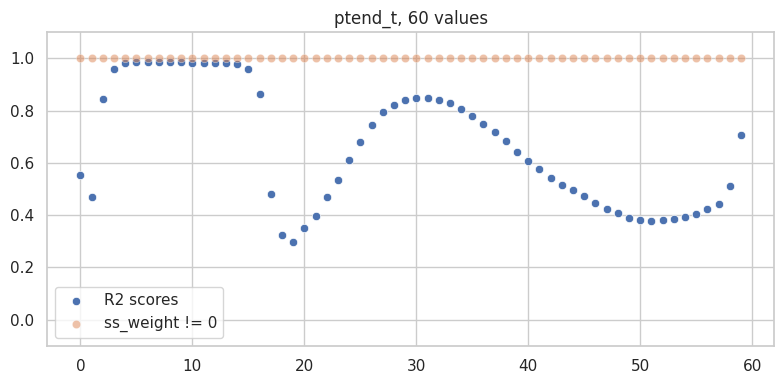

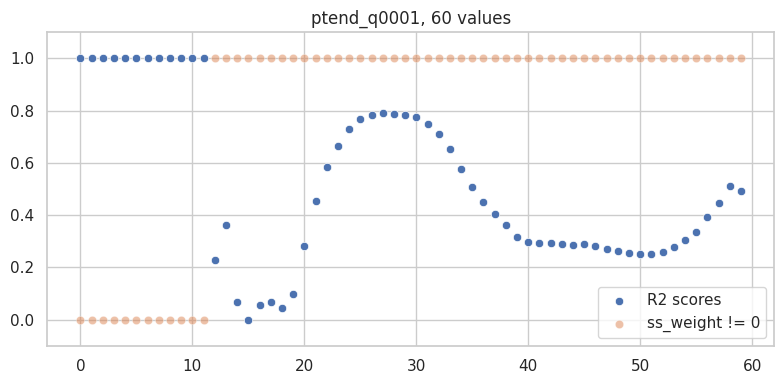

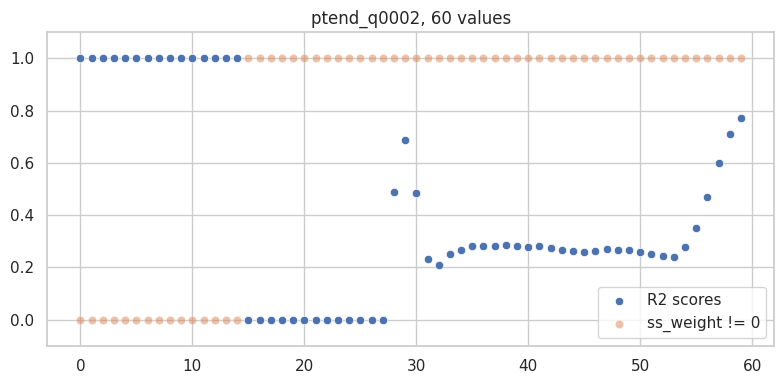

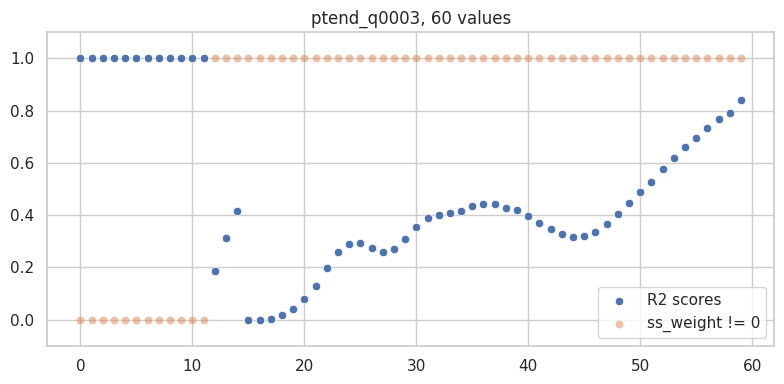

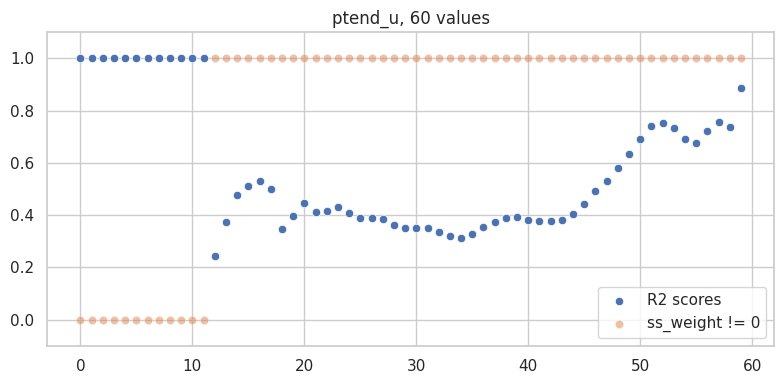

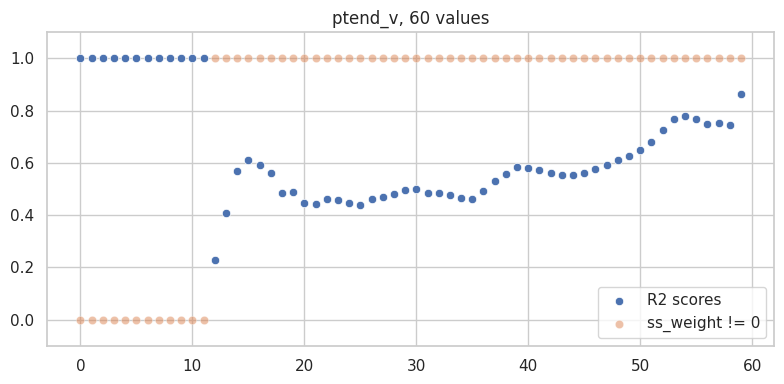

In [42]:
for col in seq_targets:
    fig, ax = plt.subplots(figsize=(8, 4))

    sns.scatterplot(
        x=range(60),
        y=[r2_score_dict[f"{col}_{i}"] for i in range(60)],
        label="R2 scores",
        ax=ax,
    )
    sns.scatterplot(
        x=range(60),
        y=[(ss_df[f"{col}_{i}"].to_numpy()[0] != 0) for i in range(60)],
        alpha=0.5,
        label="ss_weight != 0",
        ax=ax,
    )

    ax.set_title(f"{col}, 60 values")
    ax.grid(True)
    ax.set_ylim(-0.1, 1.1)
    ax.legend()

    plt.tight_layout()
    plt.show()

## single target

cam_out_NETSW : 0.9808106141358978
cam_out_FLWDS : 0.9814902033594999
cam_out_PRECSC : 0.8774537922124728
cam_out_PRECC : 0.849715273160859
cam_out_SOLS : 0.9708194022977075
cam_out_SOLL : 0.9593864067448575
cam_out_SOLSD : 0.9540897192702875
cam_out_SOLLD : 0.8793636931795064


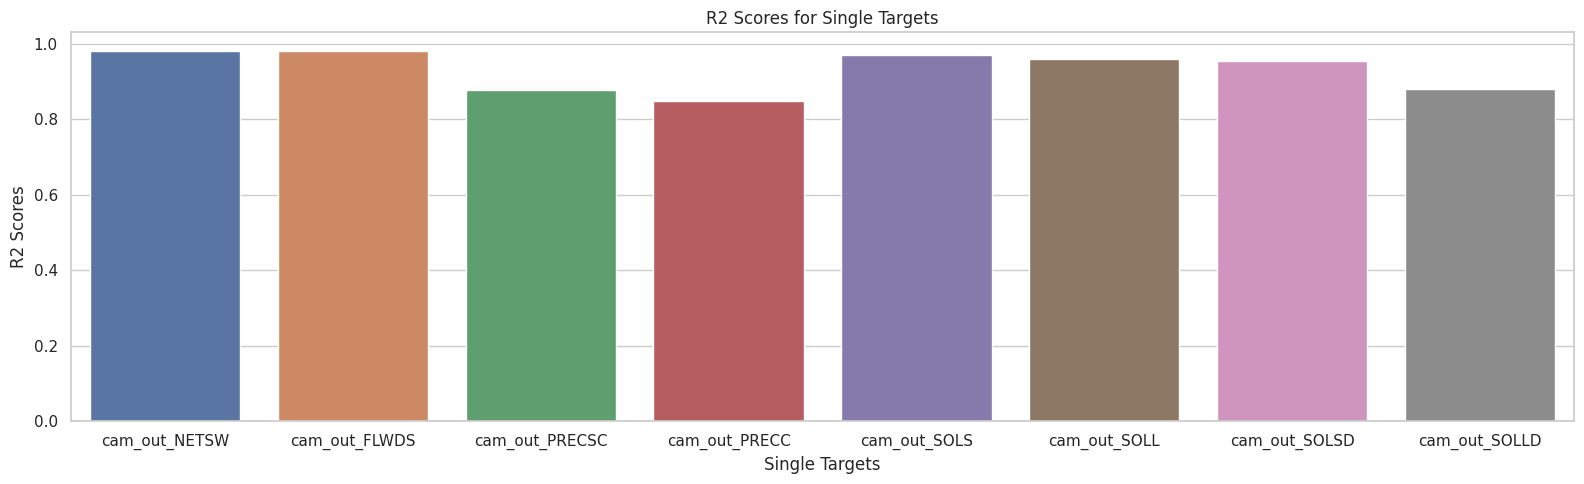

In [43]:
# single scaler target
plt.figure(figsize=(16, 5))
sns.set(style="whitegrid")

sns.barplot(
    x=np.array(single_targets),
    y=np.array([r2_score_dict[col] for col in single_targets]),
)

plt.xlabel("Single Targets")
plt.ylabel("R2 Scores")
plt.title("R2 Scores for Single Targets")

for col in single_targets:
    print(f"{col} : {r2_score_dict[col]}")

plt.tight_layout()
plt.show()

## マイナスが大きいターゲットについて確認

In [62]:
preds = predict_df[:, 1:].to_numpy()
labels = label_df[:, 1:].to_numpy()

scale_dir = ""
y_nanmean = np.load(Path(cfg.exp.scale_dir) / "y_nanmean.npy")
y_rms_sub = np.load(Path(cfg.exp.scale_dir) / "y_rms_sub.npy")
y_lower_bound = np.load(Path(cfg.exp.scale_dir) / "y_lower_bound.npy")
y_upper_bound = np.load(Path(cfg.exp.scale_dir) / "y_upper_bound.npy")


for ci, col in enumerate(target_columns):
    r2_score = r2_score_dict[col]
    if r2_score > 0.01:
        continue

    print("【", col, "】")
    print(f"{r2_score=:.5g}")

    mse = (preds[:, ci] - labels[:, ci]) ** 2
    base = (labels[:, ci] - labels[:, ci].mean()) ** 2
    ri = np.nonzero(mse == np.max(mse))[0][0]
    print(f"{ri=}, {ci=}")
    print(f"{preds[ri,ci]=:.5g}, {labels[ri,ci]=:.5g}")
    print(f"{mse[ri]=:.5g}, r2: 1-({mse.mean()=:.5g})/({base.mean()=:.5g})")

    print(f"{y_nanmean[ci]=:.5g}, {y_lower_bound[ci]=:.5g}, {y_upper_bound[ci]=:.5g}")
    print(
        f"{preds[:,ci].mean()=:.5g}, {preds[:,ci].min()=:.5g}, {preds[:,ci].max()=:.5g}"
    )
    print(
        f"{labels[:,ci].mean()=:.5g}, {labels[:,ci].max()=:.5g}, {labels[:,ci].min()=:.5g}"
    )
    print()

【 ptend_q0001_15 】
r2_score=-0.0016078
ri=652194, ci=75
preds[ri,ci]=-0.44488, labels[ri,ci]=436.77
mse[ri]=1.9116e+05, r2: 1-(mse.mean()=0.78104)/(base.mean()=0.77979)
y_nanmean[ci]=-1.0006e-13, y_lower_bound[ci]=-4.704e-11, y_upper_bound[ci]=3.6409e-11
preds[:,ci].mean()=-0.004364, preds[:,ci].min()=-1.6459, preds[:,ci].max()=0.54246
labels[:,ci].mean()=0.0008193, labels[:,ci].max()=436.77, labels[:,ci].min()=-208.35

【 ptend_q0002_15 】
r2_score=-1.2591e-06
ri=776227, ci=135
preds[ri,ci]=-1.0972e-42, labels[ri,ci]=-2.0366e-35
mse[ri]=4.1479e-70, r2: 1-(mse.mean()=2.9584e-76)/(base.mean()=2.9583e-76)
y_nanmean[ci]=-7.4269e-61, y_lower_bound[ci]=-6.5797e-57, y_upper_bound[ci]=3.2898e-57
preds[:,ci].mean()=-4.9067e-45, preds[:,ci].min()=-4.2072e-42, preds[:,ci].max()=8.9819e-44
labels[:,ci].mean()=-2.0768e-41, labels[:,ci].max()=0, labels[:,ci].min()=-2.0366e-35

【 ptend_q0002_16 】
r2_score=-2.896e-06
ri=911843, ci=136
preds[ri,ci]=0, labels[ri,ci]=-3.5408e-31
mse[ri]=1.2537e-61, r2: 1-